# Variational AutoEncoder (VAE)

In [37]:
import tensorflow as tf
from tensorflow.keras import layers, Model, Input
import numpy as np
import matplotlib.pyplot as plt

!rm -f utils.py
!wget https://raw.githubusercontent.com/francesco-zatto/vae-mnist/master/utils.py
import utils

--2025-05-14 13:53:08--  https://raw.githubusercontent.com/francesco-zatto/vae-mnist/master/utils.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3632 (3.5K) [text/plain]
Saving to: ‘utils.py’

utils.py            100%[===================>]   3.55K  --.-KB/s    in 0s      

2025-05-14 13:53:08 (45.5 MB/s) - ‘utils.py’ saved [3632/3632]



## Data preparation

In [15]:
from tensorflow.keras.datasets import mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = x_train.astype("float32") / 255.0
x_test = x_test.astype("float32") / 255.0

x_train = x_train[..., np.newaxis]
x_test = x_test[..., np.newaxis]

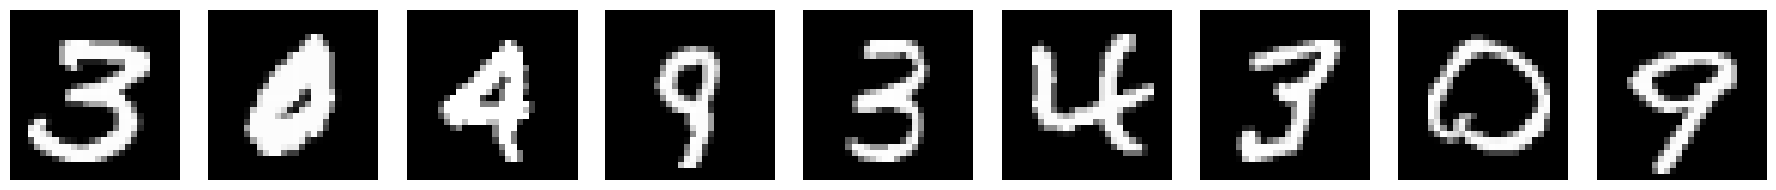

In [36]:
N_IMAGES = 9
indices = np.random.choice(len(x_train), N_IMAGES, replace=False)
images = x_train[indices]

plt.figure(figsize=(2 * N_IMAGES, 2))
for i in range(N_IMAGES):
    plt.subplot(1, N_IMAGES, i + 1)
    plt.imshow(images[i], cmap="gray")
    plt.axis("off")
plt.tight_layout()
plt.show()

## Training

In [38]:
encoder = utils.build_encoder(utils.MNIST_IMG_SHAPE)
decoder = utils.build_decoder()
vae = utils.VAE(encoder, decoder)
vae.compile(optimizer=tf.keras.optimizers.Adam(1e-3))

history = vae.fit(
    x_train,
    batch_size=64,
    epochs=30
)

UnboundLocalError: cannot access local variable 'labels' where it is not associated with a value

## Testing

In [ ]:
# Show real images reconstruction
def show_images_reconstruction(vae_model: VAE, x_test, label=None, n=16, plot=True):
  real_images = x_test[:n]
  if label is not None:
    # Conditional VAE
    real_labels = label[:n]
    z_mean, z_log_var = vae_model.encoder.predict([real_images, real_labels])
    z = vae_model.sampler([z_mean, z_log_var])
    recon_images = vae_model.decoder.predict([z, real_labels])
    print(recon_images.shape)
  else:
    # VAE
    z_mean, z_log_var = vae_model.encoder.predict(real_images)
    z = vae_model.sampler([z_mean, z_log_var])
    recon_images = vae_model.decoder.predict(z)

  if plot:
    plt.figure(figsize=(20, 4))
    for i in range(n):
        # Original
        ax = plt.subplot(2, n, i + 1)
        plt.imshow(real_images[i])
        plt.axis("off")

        # Reconstructed
        ax = plt.subplot(2, n, i + 1 + n)
        plt.imshow(recon_images[i])
        plt.axis("off")

    plt.suptitle("Top: Original | Bottom: Reconstruction")
    plt.show()

  return recon_images

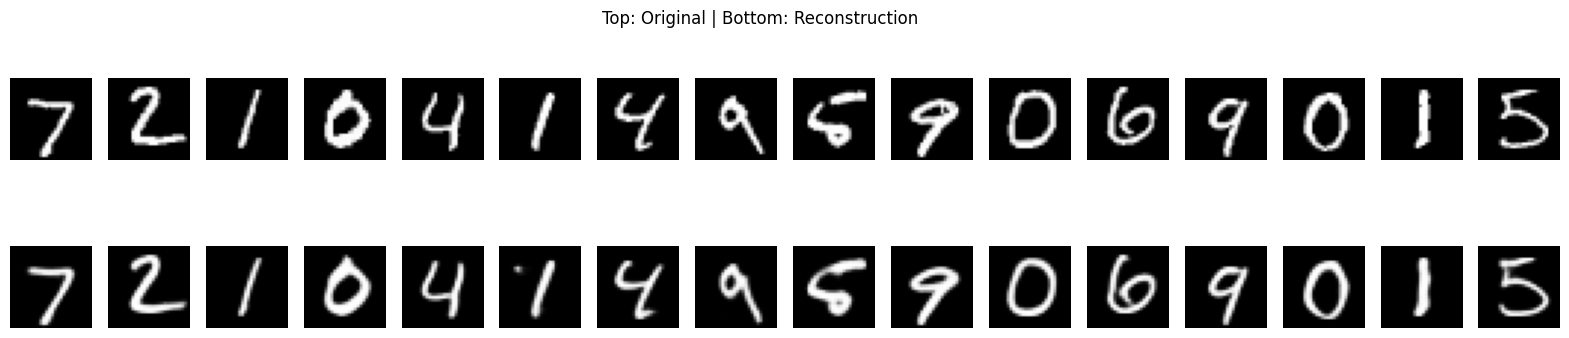

In [ ]:
show_images_reconstruction(vae, x_test)

In [ ]:
def get_labels_from_one_hots(one_hots):
  return np.argmax(one_hots, axis=1) if one_hots is not None else None

def sample_and_plot(decoder, n=10, label=None):
    z_random = tf.random.normal(shape=(n, LATENT_DIM))
    if label is not None:
      gen_labels = label[:n]
      generated = decoder.predict([z_random, gen_labels])
      num_labels = get_labels_from_one_hots(gen_labels)
    else:
      generated = decoder.predict(z_random)


    plt.figure(figsize=(20, 2))
    for i in range(n):
        ax = plt.subplot(1, n, i + 1)
        plt.imshow(generated[i], cmap="gray")
        if label is not None:
          plt.title(num_labels[i])
        plt.axis("off")
    plt.suptitle("Randomly Generated Images")
    plt.show()

In [ ]:
sample_and_plot(vae.decoder)

# Conditional VAE

## Label one-hot encoding

## Training

In [ ]:
from sklearn.preprocessing import OneHotEncoder

ohe = OneHotEncoder()
ohe.fit(y_train.reshape(-1, 1))
y_train_one_hot = ohe.transform(y_train.reshape(-1, 1)).toarray()
y_test_one_hot = ohe.transform(y_test.reshape(-1, 1)).toarray()
y_train_one_hot.shape

(60000, 10)

In [ ]:
params= {
    "img_shape": IMG_SHAPE,
    "conditional": True,
}
cond_encoder = build_encoder(**params)
cond_decoder = build_decoder(**params)
cvae = VAE(cond_encoder, cond_decoder)
cvae.compile(optimizer=tf.keras.optimizers.Adam(1e-3))

cvae.fit(
    [x_train, y_train_one_hot],
    batch_size=64,
    epochs=30
)

Epoch 1/30
938/938 ━━━━━━━━━━━━━━━━━━━━ 13s 9ms/step - loss: 0.0092
Epoch 2/30
938/938 ━━━━━━━━━━━━━━━━━━━━ 15s 6ms/step - loss: 0.0092
Epoch 3/30
938/938 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - loss: 0.0092
Epoch 4/30
938/938 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 0.0091
Epoch 5/30
938/938 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - loss: 0.0091
Epoch 6/30
938/938 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - loss: 0.0091
Epoch 7/30
938/938 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 0.0091
Epoch 8/30
938/938 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - loss: 0.0090
Epoch 9/30
938/938 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - loss: 0.0090
Epoch 10/30
938/938 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 0.0090
Epoch 11/30
938/938 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 0.0090
Epoch 12/30
938/938 ━━━━━━━━━━━━━━━━━━━━ 11s 6ms/step - loss: 0.0090
Epoch 13/30
938/938 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 0.0089
Epoch 14/30
938/938 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - loss: 0.0089
Epoch 15/30
938/938 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step

## Testing

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


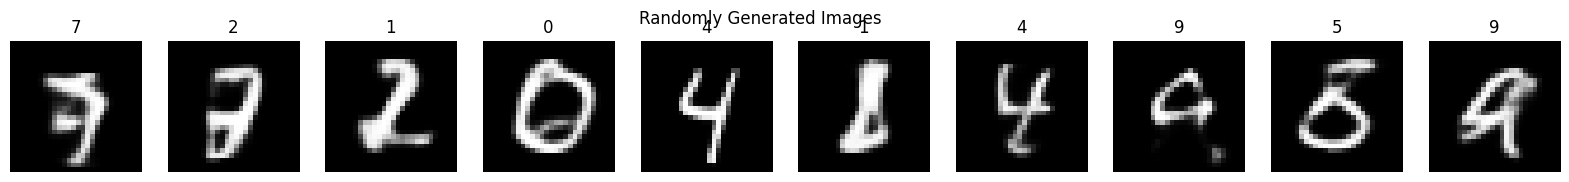

In [ ]:
sample_and_plot(cvae.decoder, label=y_test_one_hot[:10])

## Visualization of CVAE latent space

In [ ]:
from sklearn.decomposition import PCA

latent_space, variances = cond_encoder.predict([x_test, y_test_one_hot])
pca = PCA(n_components=2)
xs, ys = pca.fit_transform(latent_space).T

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


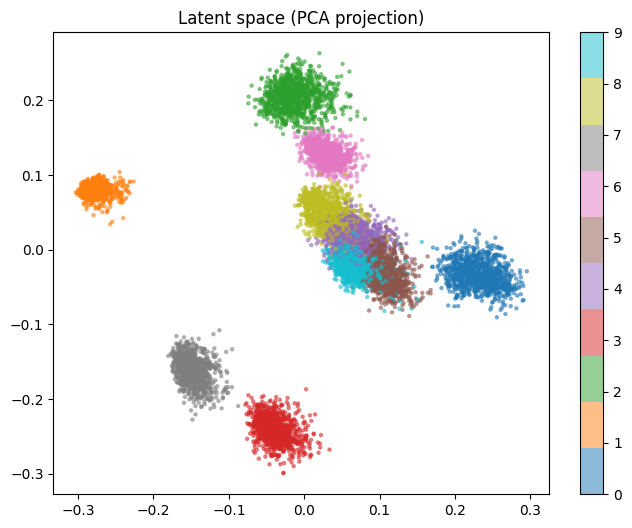

In [ ]:
plt.figure(figsize=(8, 6))
plt.scatter(xs, ys, c=y_test, cmap="tab10", alpha=0.5, s=5)
plt.colorbar()
plt.title("Latent space (PCA projection)")
plt.show()

# CVAE with CIFAR10

In [ ]:
CIFAR_IMG_SHAPE = (32, 32, 3)

(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()

print(f'Training data shape: {x_train.shape}')
print(f'Test data shape: {x_test.shape}')

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
Training data shape: (50000, 32, 32, 3)
Test data shape: (10000, 32, 32, 3)


## Training

In [ ]:
from sklearn.preprocessing import OneHotEncoder

ohe = OneHotEncoder()
ohe.fit(y_train.reshape(-1, 1))
y_train_one_hot = ohe.transform(y_train.reshape(-1, 1)).toarray()
y_test_one_hot = ohe.transform(y_test.reshape(-1, 1)).toarray()
y_train_one_hot.shape

(50000, 10)

In [ ]:
# Decode from the latent space the original image
def build_cifar_decoder(conditional=False, num_classes=10):
  latent_inputs = Input(shape=(LATENT_DIM,))
  if conditional:
    labels = Input(shape=(num_classes,))
    concat_inputs = layers.Concatenate()([latent_inputs, labels])

  x = layers.Dense(7 * 7 * LATENT_DIM, activation='relu')(concat_inputs if conditional else latent_inputs)
  x = layers.Reshape((7, 7, LATENT_DIM))(x)
  x = layers.Conv2DTranspose(64, KERNEL_SIZE, strides=2, padding='same', activation='relu')(x)
  x = layers.Conv2DTranspose(32, KERNEL_SIZE, strides=2, padding='same', activation='relu')(x)
  outputs = layers.Conv2DTranspose(3, KERNEL_SIZE+1, padding='valid', activation='sigmoid')(x)
  return Model([latent_inputs, labels], outputs, name='cifar_decoder')

In [ ]:
params= {
    "conditional": True
}
cond_encoder = build_encoder(CIFAR_IMG_SHAPE, **params)
cond_decoder = build_cifar_decoder(**params)
cvae_cifar = VAE(cond_encoder, cond_decoder)
cvae_cifar.compile(optimizer=tf.keras.optimizers.Adam(1e-4))

cvae_cifar.fit(
    [x_train, y_train_one_hot],
    batch_size=32,
    epochs=20
)

Epoch 1/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 313s 198ms/step - loss: 19747930112.0000
Epoch 2/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 329s 210ms/step - loss: 18632.7344
Epoch 3/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 344s 186ms/step - loss: 18516.4297
Epoch 4/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 255s 163ms/step - loss: 18440.8281
Epoch 5/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 254s 163ms/step - loss: 18388.7891
Epoch 6/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 261s 162ms/step - loss: 18466.9062
Epoch 7/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 250s 160ms/step - loss: 18402.7910
Epoch 8/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 262s 160ms/step - loss: 18444.4766
Epoch 9/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 263s 161ms/step - loss: 18496.4160
Epoch 10/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 259s 159ms/step - loss: 18505.2676
Epoch 11/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 263s 160ms/step - loss: 18433.5742
Epoch 12/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 262s 160ms/step - loss: 18385.6973
Epoch 13/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 248s 159ms/step - loss: 

## Testing

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
(16, 32, 32, 3)


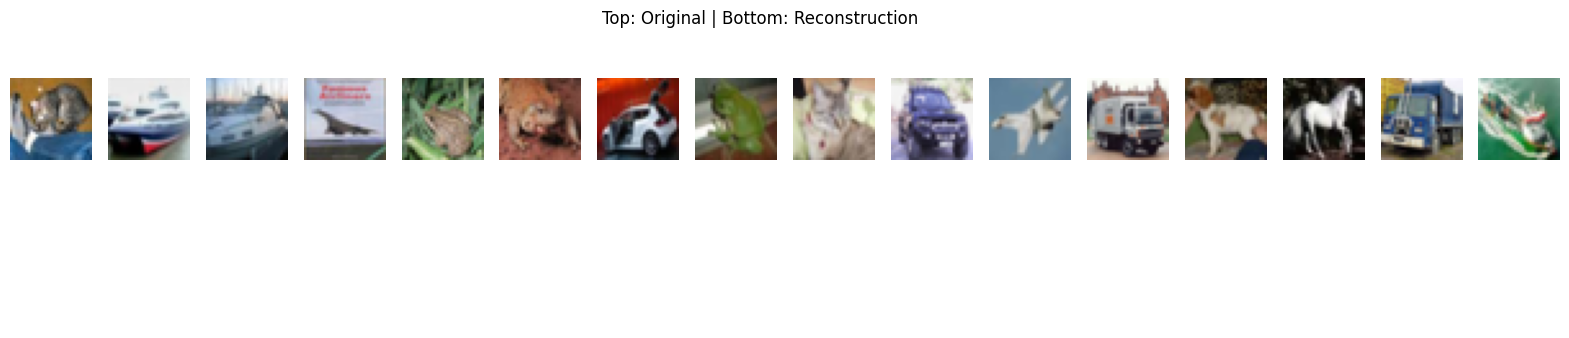

In [ ]:
_ = show_images_reconstruction(cvae_cifar, x_test, label=y_test_one_hot)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step


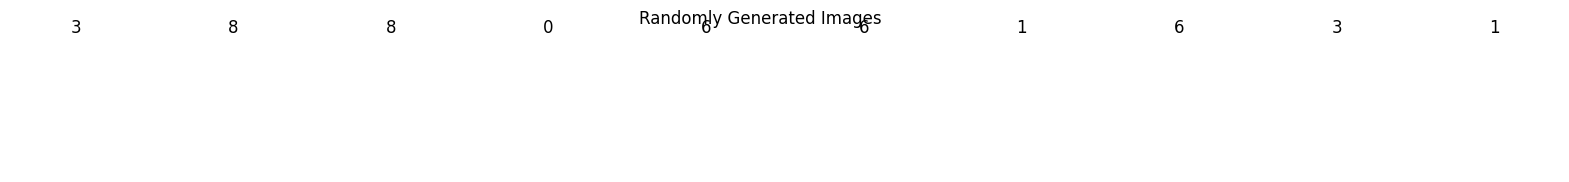

In [ ]:
sample_and_plot(cvae_cifar.decoder, label=y_test_one_hot)